<a href="https://colab.research.google.com/github/pabloesteban2712/neural-net-pets/blob/main/Neural_net_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto de clasificación de imágenes.

1. Preparar el conjunto de datos de entenamiento.
2. Arquitectura.
3. Configurar proceso de aprendizaje.
4. Entrena la RNA con nuestros datos con el metodo fit().
5. Realiza la predicción para (posibles) nuevos ejemplos que no estan en nuestro conjunto de datos.

In [27]:
from tensorflow import keras

In [39]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [40]:
#Descargamos el dataset
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   156M      0  0:00:05  0:00:05 --:--:--  164M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [41]:
# Ruta del conjunto
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!unzip -d /content/drive/MyDrive/model_pets kagglecatsanddogs_5340.zip

Archive:  kagglecatsanddogs_5340.zip
replace /content/drive/MyDrive/model_pets/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/0.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/1.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/100.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/1000.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10000.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10001.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10002.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10003.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10004.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10005.jpg  
  inflating: /content/drive/MyDrive/model_pets/PetImages/Cat/10006.jpg 

In [43]:
# Ruta del conjunto de datos
DATASET_PATH = "/content/PetImages"

In [44]:
import tensorflow as tf
import os

def filter_images():
  deleted_imgs = 0
  for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(DATASET_PATH, folder_name)

    for image in os.listdir(folder_path):
      img_path = os.path.join(folder_path, image)
      try:
        fobj = open(img_path, "rb")

        # Aqui se comprueba si esta en el formato adecuado (JPEG)
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)

      finally:
        fobj.close()
      if not is_jfif:
        deleted_imgs +=1
        # Si no está en el formato adecuado eliminamos la imagen
        os.remove(img_path)

  print(f"Imágenes eliminadas: {deleted_imgs}")

In [45]:
filter_images()

Imágenes eliminadas: 1590


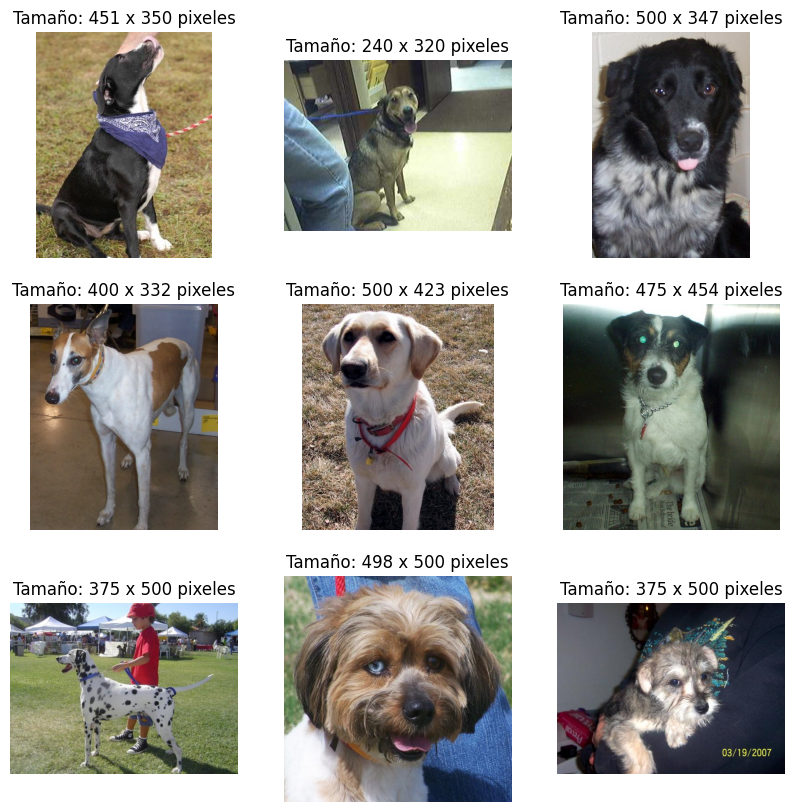

In [46]:
# Vamos a analizar el tamaño con una muestra

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10,10))

folder_path = os.path.join(DATASET_PATH, "Dog")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pixeles")
  plt.axis("off")

plt.show()

In [47]:
image_size = (180, 180)
batch_size = 128 # Las procesamos en lotes

train_ds = keras.utils.image_dataset_from_directory (
    DATASET_PATH,
    validation_split = 0.2, # 80% entrenamiento, 20% prueba
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


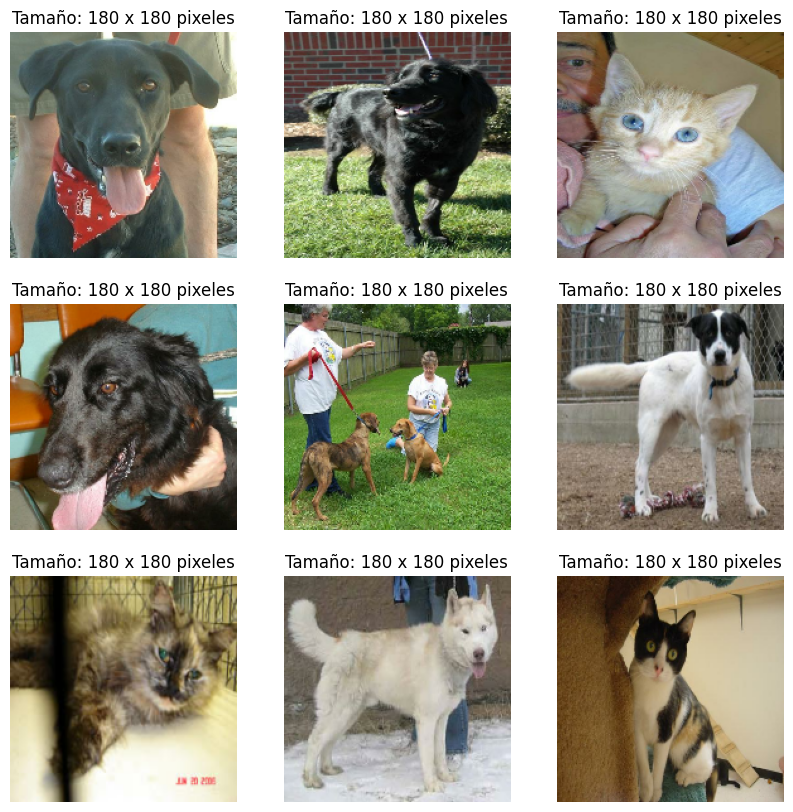

In [48]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} pixeles")
    plt.axis("off")

plt.show()

In [49]:
temp_val_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2, # 20% de los datos son de validacion (y pruebas)
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [50]:
val_size = int(0.5 * len(temp_val_ds))

In [51]:
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

In [52]:
val_ds_sk = list(temp_val_ds)

In [53]:
from sklearn.model_selection import train_test_split

val_ds_sk, test_ds_sk = train_test_split(
    val_ds_sk,
    test_size=0.5, # prueba
    random_state=42, # semilla de reproductividad
)

In [54]:
# Aqui definimos la red neuronal
from keras import layers

input_shape = (180, 180, 3)

# Dimensiones imagenes
fcnn_model = keras.Sequential()

# Entrada red
fcnn_model.add(layers.Input(shape=input_shape))

# Escalamos las imagenes de 0 a 1
fcnn_model.add(layers.Rescaling(1.0 / 255))

# Aplanamos las imagenes
fcnn_model.add(layers.Flatten())

# Layer 1
fcnn_model.add(layers.Dense(384, activation='relu'))

# Layer 2
fcnn_model.add(layers.Dense(256, activation='relu'))

# Layer 3
fcnn_model.add(layers.Dense(128, activation='relu'))

# Layer 4 (Out)
fcnn_model.add(layers.Dense(1, activation='sigmoid'))

In [55]:
fcnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │      37,325,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,456,769 (142.89 MB)

 Trainable params: 37,456,769 (142.89 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
fcnn_model.layers

[<Rescaling name=rescaling, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

In [57]:
hidden1 = fcnn_model.layers[2]

In [58]:
weights, biases = hidden1.get_weights()

In [59]:
fcnn_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [61]:
history = fcnn_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.5335 - loss: 1.0247 - val_accuracy: 0.6367 - val_loss: 0.6416
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5812 - loss: 0.6857 - val_accuracy: 0.6445 - val_loss: 0.6333
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.5935 - loss: 0.6726 - val_accuracy: 0.4870 - val_loss: 1.5056
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5704 - loss: 0.7508 - val_accuracy: 0.6185 - val_loss: 0.6515
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.6219 - loss: 0.6458 - val_accuracy: 0.6502 - val_loss: 0.6310
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.6280 - loss: 0.6406 - val_accuracy: 0.6480 - val_loss: 0.6235
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.6172 - loss: 0.6536 - val_accuracy: 0.6302 - val_loss: 0.6396
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - accuracy: 0.6266 - loss: 0

Guardamos nuestro modelo en disco

In [63]:
fcnn_model.save("/content/drive/MyDrive/model_pets/PetImages/modelo_fcnn_cats_vs_dogs.keras")

In [64]:
fcnn_model_disk = keras.models.load_model("/content/drive/MyDrive/model_pets/PetImages/modelo_fcnn_cats_vs_dogs.keras")

In [65]:
evaluation_result = fcnn_model_disk.evaluate(test_ds)

print("Loss:", evaluation_result[0])
print("Accuraccy:", evaluation_result[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.6706 - loss: 0.6092
Loss: 0.6124886274337769
Accuraccy: 0.6669470071792603


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-66-bfac7164aacf>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


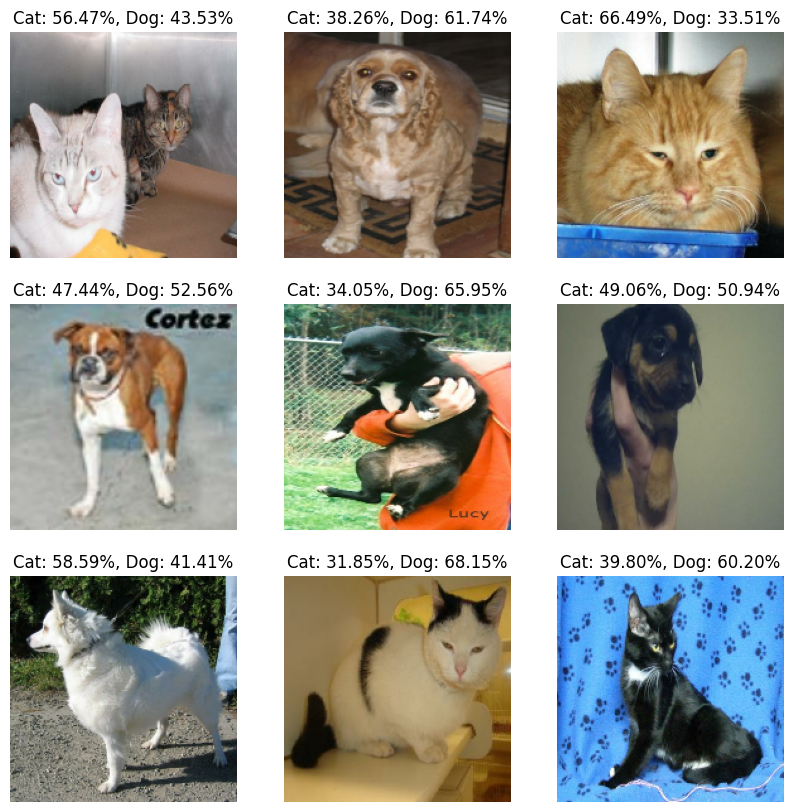

In [66]:
plt.figure(figsize=(10,10))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predictions = fcnn_model_disk.predict(tf.expand_dims(images[i],0))
    score = float(predictions[0])
    plt.title(f"Cat: {100 * (1 - score):.2f}%, Dog: {100 * score:.2f}%")
    plt.axis("off")

plt.show()

Vamos a mejorar los resultados obtenidos

In [26]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)